# Benchmarking LightGBM

This chapter aims to benchmark the trained LightGBM Regressor of the previous chapter with other machine learning models. The goal is to compare the performance of LightGBM with these models in order to gain better insights into LightGBMs strengths and weaknesses. In order to evaluate the performance of all three models, we use the used cars dataset again. We replicate the structure from Chapter 2.2 and apply the exact same preprocessing steps: Categorical features are again label encoded and the data is split in the same way. All models are first trained with default hyperparameters. Afterwards, we tune the hyperparameters via optuna. In order to make the results comparable, we use 10 iterations per hyperparameter to be optimized in order to find optimized hyperparameters for all models. Again, we stored the hyperparameters we found when running the optimization. You have the opportunity to uncomment the optimization cells again and run it yourself. This may be computationally time-consuming.

Alongside **LightGBM**, we examine **Decision Tree Regressor** and **XGBoost** as baseline models. There are multiple reasons for choosing these two models. Firstly, both of them are capable of performing regression tasks. XGBoost is of particular interest in our investigation. LightGBM and XGBoost are both gradient boosting machines, with LightGBM providing some optimized algorithms "on top" (cf. Chapter 1). The benchmarking aims to find out to which extent LightGBMs performance is improved by these algorithms. 
Decision Tree Regressor is stated as a baseline as decision trees form the foundation of boosting algorithms in most cases, in the form of weak learners. By using a stand alone decision tree, we aim to find out to which extent one (stronger) learner can keep up with multiple (weak) learners of the same structure (decision tree).

Generally, we set RMSE to be the error metric the model should reduce during training. For Decision Tree Regressor, however, there is no such option. This is why we use MSE (Mean Squared Error) in this case. As this metric also relies on putting more emphasis on larger errors, the performance of the Decision Tree Regressor should not be affected too much by this choice.

In [52]:
# Run helper code in utilities
%run ../utilities.ipynb

In [53]:
# Load cleaned data
df_cars = pd.read_csv("data/cars_cleaned.csv")

## 1. Data Splitting and Preparation

In [54]:
# Encode categorical features of car dateset as numerical ones
cat_features = ["brand", "model", "color", "transmission_type", "fuel_type"]

# Fit label encoder
label_encoders = defaultdict(LabelEncoder)
fit = df_cars[cat_features].apply(lambda x: label_encoders[x.name].fit_transform(x))

# Apply label encoder to dataset
df_cars[cat_features] = df_cars[cat_features].apply(
    lambda x: label_encoders[x.name].transform(x)
)

In [55]:
# Separate feature and target variables
X = df_cars.drop("price_in_euro", axis=1)
y = df_cars.price_in_euro

In [56]:
# Split data into train and test sets
# Stratify ensures that the proportion of car models contained in the test and train set are similar and that
# each car model in the test set is at least once contained in the training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42, shuffle=True, stratify=X["model"]
)

## 2. Model Training and Tuning

In [57]:
# Initialize empty DataFrame for later error metric comparison of the models
df_metric_comparison = pd.DataFrame(
    {
        "model_name": pd.Series(dtype="str"),
        "optimized": pd.Series(dtype="bool"),
        "metric_name": pd.Series(dtype="str"),
        "metric_value": pd.Series(dtype="float"),
    }
)

### 2.1 Decision Tree Regressor

#### 2.1.1 Implementation with Default Hyperparameters

**Training**

In [58]:
# Define hyperparameters for training the Decision Tree Regressor
# All values are defaults and just listed for illustration purposes
params_dt = {
    "criterion": "squared_error",
    "splitter": "best",
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_features": None,
    "random_state": 42,
}

For more information on hyperparameters see the [documentation](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html) of Scikit-learn.

In [59]:
# Instantiate Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(**params_dt)

# Fit the regressor using the training data
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

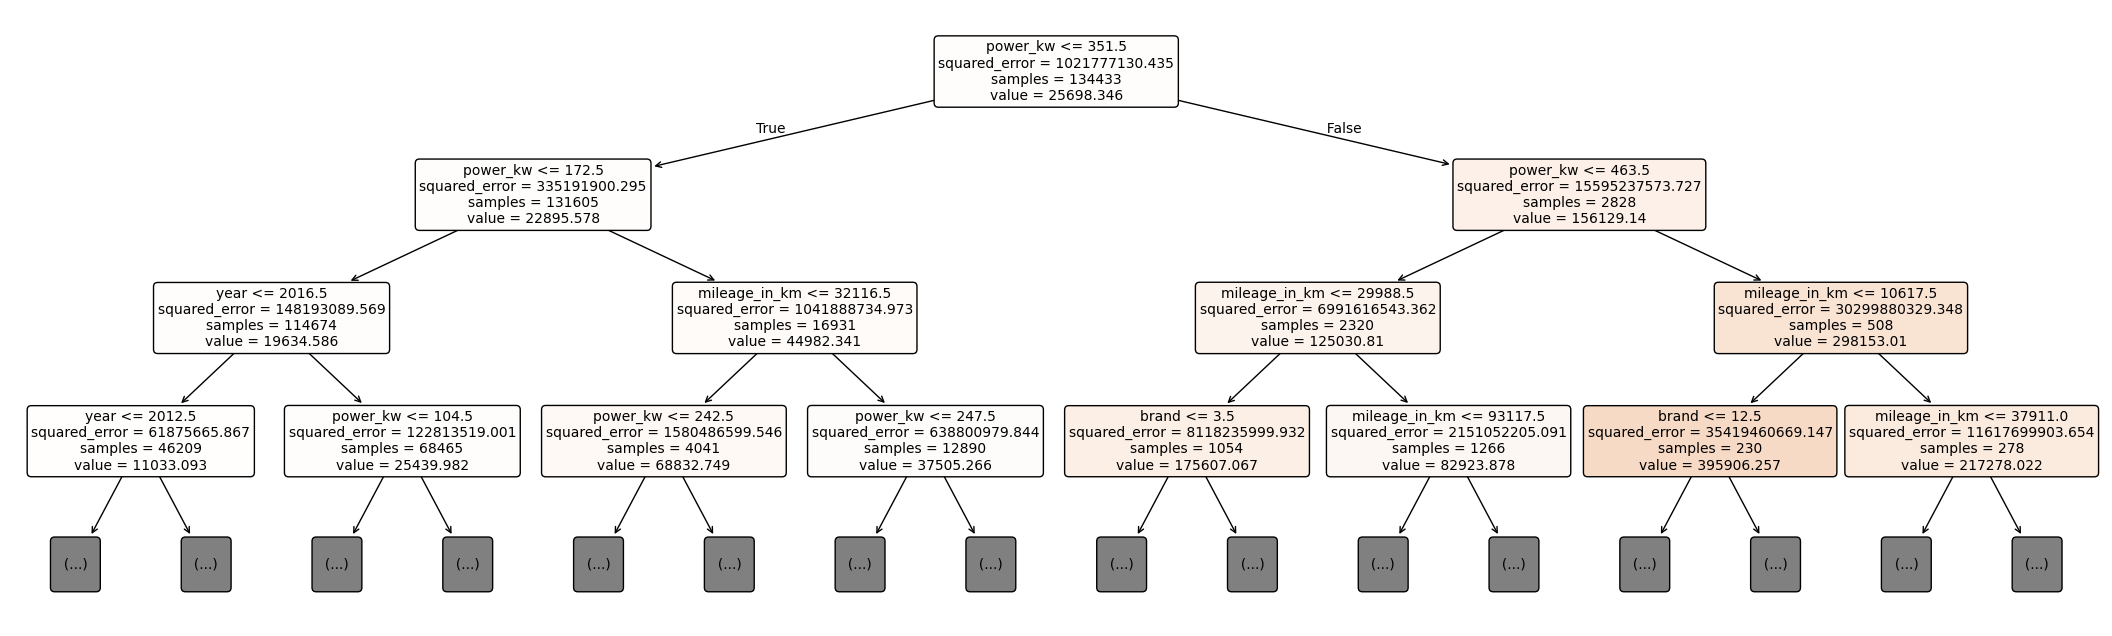

In [60]:
# Display the first three layers of the trained decision tree for illustration purposes
fig_structure_dt = plt.figure(figsize=(27, 8))
_ = tree.plot_tree(
    dt_regressor,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3,
)

**Testing**

In [61]:
# Perform prediction on test data
y_pred_dt = dt_regressor.predict(X_test)

In [62]:
# Calculate error metrics
rmse_dt = metrics.root_mean_squared_error(y_test, y_pred_dt)
mae_dt = metrics.mean_absolute_error(y_test, y_pred_dt)
mape_dt = metrics.mean_absolute_percentage_error(y_test, y_pred_dt)

print(f"Root Mean Squared Error (RMSE): {rmse_dt}")
print(f"Mean Absolute Error (MAE): {mae_dt}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dt}")

# Store error metrics for later comparison
for key, value in zip(["rmse", "mae", "mape"], [rmse_dt, mae_dt, mape_dt]):
    df_metric_comparison.loc[len(df_metric_comparison)] = [
        "dt_regressor",
        False,
        key,
        value,
    ]

Root Mean Squared Error (RMSE): 15706.234491153362
Mean Absolute Error (MAE): 4663.817322813071
Mean Absolute Percentage Error (MAPE): 0.22079938104838043


#### 2.1.2 Hyperparameter Optimization

**Hyperparameter Search**

In [63]:
# Hardcoded optimized hyperparameters (so that running the optimization cell below is not necessary as the computation may be time-consuming)
params_dt_opt = {
    "max_depth": 32,
    "min_samples_split": 17,
    "min_samples_leaf": 15,
    "min_weight_fraction_leaf": 0.0004304221705147566,
    "max_features": 10,
    "criterion": "squared_error",
    "splitter": "best",
    "random_state": 42,
}

In [64]:
# # Set seed to get reproducible results
# sampler_dt = optuna.samplers.TPESampler(seed=42)
#
# # Run optuna optimization in order to find the best possible hyperparameters
# # Goal: Reduce the cost funtion (RMSE) of the Decision Tree Regressor
# study_dt = optuna.create_study(sampler=sampler_dt, direction="minimize")
# study_dt.optimize(objective_dt, n_trials=60)
#
# # Return the best hyperparammeters and the related RMSE value
# print("Best hyperparameters found:", study_dt.best_params)
# print("Best RMSE:", study_dt.best_value)
#
# # Set the hyperparameters to the optimized ones
# params_dt_opt = study_dt.best_params
#
# # Add unchanged parameters
# params_dt_opt.update(
#     {"criterion": "squared_error", "splitter": "best", "random_state": 42}
# )

**Training and Testing With Optimized Hyperparameters**

In [65]:
# Retrain Decision Tree Regressor with optimized hyperparameters
dt_regressor_opt = DecisionTreeRegressor(**params_dt_opt)
dt_regressor_opt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=32, max_features=10, min_samples_leaf=15,
                      min_samples_split=17,
                      min_weight_fraction_leaf=0.0004304221705147566,
                      random_state=42)

In [66]:
# Perform prediction on test data
y_pred_dt_opt = dt_regressor_opt.predict(X_test)

In [67]:
# Calculate error metrics
rmse_dt_opt = metrics.root_mean_squared_error(y_test, y_pred_dt_opt)
mae_dt_opt = metrics.mean_absolute_error(y_test, y_pred_dt_opt)
mape_dt_opt = metrics.mean_absolute_percentage_error(y_test, y_pred_dt_opt)

print(
    f"Root Mean Squared Error (RMSE): {rmse_dt_opt}    (before optimization: {rmse_dt})"
)
print(f"Mean Absolute Error (MAE): {mae_dt_opt}    (before optimization: {mae_dt})")
print(
    f"Mean Absolute Percentage Error (MAPE): {mape_dt_opt}    (before optimization: {mape_dt})"
)

# Store error metrics for later comparison
for key, value in zip(["rmse", "mae", "mape"], [rmse_dt_opt, mae_dt_opt, mape_dt_opt]):
    df_metric_comparison.loc[len(df_metric_comparison)] = [
        "dt_regressor",
        True,
        key,
        value,
    ]

Root Mean Squared Error (RMSE): 13567.396257269022    (before optimization: 15706.234491153362)
Mean Absolute Error (MAE): 4612.482428366434    (before optimization: 4663.817322813071)
Mean Absolute Percentage Error (MAPE): 0.20265123504793126    (before optimization: 0.22079938104838043)


### 2.3 XGBoost

#### 2.3.1 Implementation with Default Hyperparameters

**Training**

In [68]:
# Define hyperparameters for training the XGBoost Regressor
# All values are defaults and just listed for illustration purposes
params_xgb = {
    "eta": 0.3,
    "gamma": 0,
    "max_depth": 6,
    "min_child_weight": 1,
    "max_delta_step": 0,
    "subsample": 1,
    "colsample_bytree": 1,
    "lambda": 1,
    "alpha": 0,
    "n_estimators": 100,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}

For more information on hyperparameters see the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html) of XGBoost.

In [69]:
# Instantiate XGB Regressor
xgb_regressor = xg.XGBRegressor(**params_xgb)

# Fit the regressor using the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.3, eval_metric='rmse', feature_types=None, gamma=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=6, max_leaves=None, min_child_weight=1,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=100, ...)

**Testing**

In [70]:
# Perform prediction on test data
y_pred_xgb = xgb_regressor.predict(X_test)

In [71]:
# Calculate error metrics
rmse_xgb = metrics.root_mean_squared_error(y_test, y_pred_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = metrics.mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb}")

# Store error metrics for later comparison
for key, value in zip(["rmse", "mae", "mape"], [rmse_xgb, mae_xgb, mape_xgb]):
    df_metric_comparison.loc[len(df_metric_comparison)] = [
        "xgb_regressor",
        False,
        key,
        value,
    ]

Root Mean Squared Error (RMSE): 10529.005739231523
Mean Absolute Error (MAE): 3654.421257871217
Mean Absolute Percentage Error (MAPE): 0.17188176024994775


#### 2.3.2 Hyperparameter Optimization

**Hyperparameter Search**

In [72]:
# Hardcoded optimized hyperparameters (so that running the optimization cell below is not necessary as the computation may be time-consuming)
params_xgb_opt = {
    "eta": 0.09003242497634299,
    "gamma": 45,
    "max_depth": 19,
    "min_child_weight": 2,
    "max_delta_step": 0,
    "subsample": 0.710652376823672,
    "colsample_bytree": 0.4670533748910389,
    "lambda": 8,
    "alpha": 7,
    "n_estimators": 110,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}

In [73]:
# Set seed to get reproducible results
# sampler_xgb = optuna.samplers.TPESampler(seed=42)

# # Run optuna optimization in order to find the best possible hyperparameters
# # Goal: Reduce the cost funtion (RMSE) of the XGBoost Regressor
# study_xgb = optuna.create_study(sampler=sampler_xgb, direction="minimize")
# study_xgb.optimize(objective_xgb, n_trials=60)
#
# # Return the best hyperparammeters and the related RMSE value
# print("Best hyperparameters found:", study_xgb.best_params)
# print("Best RMSE:", study_xgb.best_value)
#
# # Set the hyperparameters to the optimized ones
# params_xgb_opt = study_xgb.best_params
#
# # Add unchanged parameters
# params_xgb_opt.update({"objective": "reg:squarederror", "eval_metric": "rmse"})

**Training and Testing With Optimized Hyperparameters**

In [74]:
# Retrain XGB Regressor with optimized hyperparameters
xgb_regressor_opt = xg.XGBRegressor(**params_xgb_opt)
xgb_regressor_opt.fit(X_train, y_train)

XGBRegressor(alpha=7, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4670533748910389, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.09003242497634299, eval_metric='rmse', feature_types=None,
             gamma=45, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=8, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=19, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, ...)

In [75]:
# Perform prediction on test data
y_pred_xgb_opt = xgb_regressor_opt.predict(X_test)

In [76]:
# Calculate error metrics
rmse_xgb_opt = metrics.root_mean_squared_error(y_test, y_pred_xgb_opt)
mae_xgb_opt = metrics.mean_absolute_error(y_test, y_pred_xgb_opt)
mape_xgb_opt = metrics.mean_absolute_percentage_error(y_test, y_pred_xgb_opt)

print(
    f"Root Mean Squared Error (RMSE): {rmse_xgb_opt}    (before optimization: {rmse_xgb})"
)
print(f"Mean Absolute Error (MAE): {mae_xgb_opt}    (before optimization: {mae_xgb})")
print(
    f"Mean Absolute Percentage Error (MAPE): {mape_xgb_opt}    (before optimization: {mape_xgb})"
)

# Store error metrics for later comparison
for key, value in zip(
    ["rmse", "mae", "mape"], [rmse_xgb_opt, mae_xgb_opt, mape_xgb_opt]
):
    df_metric_comparison.loc[len(df_metric_comparison)] = [
        "xgb_regressor",
        True,
        key,
        value,
    ]

Root Mean Squared Error (RMSE): 9801.907555495893    (before optimization: 10529.005739231523)
Mean Absolute Error (MAE): 3189.6895175668005    (before optimization: 3654.421257871217)
Mean Absolute Percentage Error (MAPE): 0.15393764961879813    (before optimization: 0.17188176024994775)


### 2.4 LightGBM

#### 2.4.1 Implementation with Default Hyperparameters

In [77]:
# As a LightGBM model with (mostly) default hyperparameters has already been trained on the dataset in "2.2_training_and_testing", we simply load the stored model
lgb_regressor = lgb.Booster(model_file="models/lgb_regressor.txt")

In [78]:
# Make predictions on the test set
y_pred_lgb = lgb_regressor.predict(X_test)

In [79]:
# Calculate error metrics
rmse_lgb = metrics.root_mean_squared_error(y_test, y_pred_lgb)
mae_lgb = metrics.mean_absolute_error(y_test, y_pred_lgb)
mape_lgb = metrics.mean_absolute_percentage_error(y_test, y_pred_lgb)

print(f"Root Mean Squared Error (RMSE): {rmse_lgb}")
print(f"Mean Absolute Error (MAE): {mae_lgb}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lgb}")

# Store error metrics in comparison dictionary
for key, value in zip(["rmse", "mae", "mape"], [rmse_lgb, mae_lgb, mape_lgb]):
    df_metric_comparison.loc[len(df_metric_comparison)] = [
        "lgb_regressor",
        False,
        key,
        value,
    ]

Root Mean Squared Error (RMSE): 9484.456266379444
Mean Absolute Error (MAE): 3242.5848096762543
Mean Absolute Percentage Error (MAPE): 0.16173737439128447


#### 2.4.2 Hyperparameter Optimization

In [80]:
# As the hyperparameters of the LightGBM model have already been optimized in "2.2_training_and_testing", we simply load the stored optimized model
lgb_regressor_opt = lgb.Booster(model_file="models/lgb_regressor_opt.txt")

In [81]:
# Make predictions on the test set
y_pred_lgb_opt = lgb_regressor_opt.predict(X_test)

In [82]:
# Calculate error metrics
rmse_lgb_opt = metrics.root_mean_squared_error(y_test, y_pred_lgb_opt)
mae_lgb_opt = metrics.mean_absolute_error(y_test, y_pred_lgb_opt)
mape_lgb_opt = metrics.mean_absolute_percentage_error(y_test, y_pred_lgb_opt)

print(
    f"Root Mean Squared Error (RMSE): {rmse_lgb_opt}    (before optimization: {rmse_lgb})"
)
print(f"Mean Absolute Error (MAE): {mae_lgb_opt}    (before optimization: {mae_lgb})")
print(
    f"Mean Absolute Percentage Error (MAPE): {mape_lgb_opt}    (before optimization: {mape_lgb})"
)

# Store error metrics in comparison dictionary
for key, value in zip(
    ["rmse", "mae", "mape"], [rmse_lgb_opt, mae_lgb_opt, mape_lgb_opt]
):
    df_metric_comparison.loc[len(df_metric_comparison)] = [
        "lgb_regressor",
        True,
        key,
        value,
    ]

Root Mean Squared Error (RMSE): 9261.86900189519    (before optimization: 9484.456266379444)
Mean Absolute Error (MAE): 3019.8579602374    (before optimization: 3242.5848096762543)
Mean Absolute Percentage Error (MAPE): 0.145064703922225    (before optimization: 0.16173737439128447)


## 3. Performance Comparison

The three models will now be compared in detail in this section. The error metrics as well as training time, feature importance and the learning curves will be considered.

### 3.1 Error Metrics

Now that all models have been trained with default and optimized hyperparameters and the metrics have been tracked, the error metrics can be visualized graphically:

In [83]:
# Display the error metrics of the models with default and optimized hyperparameters
for metric_name in df_metric_comparison["metric_name"].unique():
    fig_metric_comparison = px.bar(
        df_metric_comparison[(df_metric_comparison["metric_name"] == metric_name)],
        x="model_name",
        y="metric_value",
        color="optimized",
        barmode="group",
        title=f"{metric_name.upper()}",
        labels={"optimized": "hyperparameters optimized?"},
        width=900,
        height=300,
    )

    style_bar_chart(fig_metric_comparison)
    fig_metric_comparison.show()

The most important starting point for comparing the models is the error metrics. These indicate how well the individual models can map the structures in the data and apply them to unknown data. Accordingly, this section is the most decisive in our benchmarking. The error metrics are also the main reason for deciding for or against a model: If the errors are too large, even the fastest training time won't help.

It is immediately apparent that the optimization of the hyperparameters leads to a significant reduction in errors for all three models. The error ratio of the models is basically similar for all error metrics: The performance of LightGBM stands out in particular. It beats the other two models with both default and optimized hyperparameters. There is a particularly large gap for the decision tree regressor. Compared to XGBoost, LightGBM's performance is also better, but by a smaller margin. Nevertheless, the overall quality of the predictions speaks in favor of LightGBM in this use case.

### 3.2 Training Time

In addition to looking solely at the error metrics, a comprehensive analysis should also include comparing the training times of the individual models. To do this, we train all models again and record the training time of the processes. It is important to note that the training times may deviate from computer to computer. This is due to different computing powers. In the text below the following code cells, we are referring to the results we received on our computer. It may differ from the results you will receive when running the following cells.

In [84]:
# Convert Pandas DataFrames to desired lightgbm.Dataset type (used by LightGBM only)
train_set_lgb = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_features,
    free_raw_data=False,
)

test_set_lgb = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=cat_features,
    free_raw_data=False,
)

In [85]:
# Initialize empty DataFrame for training time comparison of the models
df_training_time_comparison = pd.DataFrame(
    {
        "model_name": pd.Series(dtype="str"),
        "optimized": pd.Series(dtype="bool"),
        "training_time": pd.Series(dtype="float"),
    }
)

In [86]:
# Track training time for all three models with default and optimized hyperparameters
for model in ["dt_regressor", "xgb_regressor", "lgb_regressor"]:
    for optimized in [False, True]:
        print(
            f"Training and tracking {'optimized' if optimized else 'default'} {model}"
        )
        df_training_time_comparison.loc[len(df_training_time_comparison)] = [
            model,
            optimized,
            track_training_time(model, optimized),
        ]

Training and tracking default dt_regressor
Training and tracking optimized dt_regressor
Training and tracking default xgb_regressor
Training and tracking optimized xgb_regressor
Training and tracking default lgb_regressor


c:\Users\Sidney Krause\anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\engine.py:204: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training and tracking optimized lgb_regressor


c:\Users\Sidney Krause\anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\engine.py:204: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



In [87]:
# Display the training time of the models with default and optimized hyperparameters
for i in df_training_time_comparison["optimized"].unique():
    fig_training_time_comp = px.bar(
        df_training_time_comparison[(df_training_time_comparison["optimized"] == i)],
        x="model_name",
        y="training_time",
        title=f"Training time (in seconds) of {'optimized' if i else 'default'} models",
        labels={"optimized": "hyperparameters optimized?"},
        width=900,
        height=300,
    )

    style_bar_chart(fig_training_time_comp)
    fig_training_time_comp.show()

A clear picture also emerges here. The time that the LightGBM Regressor needs for training is the longest of all three models. The Decision Tree Regressor requires the least training time by an absolute margin.

In fact, it is mainly the first image that is of interest in our study. The reason for this is that 100 iterations (100 sequentially added weak learners) are defined in the default hyperparameters for XGBoost Regressor and LightGBM Regressor. The training time is therefore more comparable. For the optimized models, the iteration numbers for XGBoost Regressor (110 iterations) and LightGBM Regressor (408 iterations) are significantly different. No fair and meaningful comparison can be made here.

In terms of the training time of the default models, however, the LightGBM Regressor is the worst performer on our dataset. LightGBM's speed advantages are particularly evident with very large datasets. Our dataset is still too small to show the corresponding advantages. In the range in which the above training times lie, the difference in speed is not the most significant, to be honest, even with the optimized models.

### 3.3 Feature Importance

In the following, the importances that the models attribute to the individual features will be compared. For this purpose, a training process of all models is started again and this time the feature importances are tracked. It is important to note that the *gain* feature importance is tracked. The gain feature importance  indicates how much a particular feature contributes to improving the predictive performance of a model, measured by summing the gain value across all splits where the feature is used. The gain measures how much the prediction accuracy of a model improves when a feature is used for a split usually by calculating the entropy before and after the split is performed.

In [88]:
# Initialize empty DataFrame for feature importance comparison of the models
df_feature_importance_comparison = pd.DataFrame(
    {
        "model_name": pd.Series(dtype="str"),
        "optimized": pd.Series(dtype="bool"),
    }
)

df_feature_importance_comparison = pd.concat(
    [
        df_feature_importance_comparison,
        pd.DataFrame({i: pd.Series(dtype="float") for i in X_train.columns}),
    ]
)

In [89]:
# Track feature importance for all three models with default and optimized hyperparameters
for model in ["dt_regressor", "xgb_regressor", "lgb_regressor"]:
    for optimized in [False, True]:
        print(
            f"Training and tracking {'optimized' if optimized else 'default'} {model}"
        )
        df_feature_importance_comparison.loc[len(df_feature_importance_comparison)] = [
            model,
            optimized,
            *track_feature_importance(model, optimized),
        ]

Training and tracking default dt_regressor
Training and tracking optimized dt_regressor
Training and tracking default xgb_regressor
Training and tracking optimized xgb_regressor
Training and tracking default lgb_regressor


c:\Users\Sidney Krause\anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\engine.py:204: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training and tracking optimized lgb_regressor


c:\Users\Sidney Krause\anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\engine.py:204: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



In [90]:
# Reshape the DataFrame to long format
df_feature_importance_comparison = df_feature_importance_comparison.melt(
    id_vars=["model_name", "optimized"],
    var_name="feature",
    value_name="importance",
)

# Add column with mean importance values by feature and optimization status (aloows sorting later on)
df_feature_importance_comparison = df_feature_importance_comparison.merge(
    df_feature_importance_comparison.groupby(["optimized", "feature"])[
        "importance"
    ].mean(),
    on=["optimized", "feature"],
).rename(columns={"importance_x": "importance", "importance_y": "importance_mean"})

In [91]:
# Display the feature importance values of the models with default and optimized hyperparameters
for optimized in df_feature_importance_comparison["optimized"].unique():
    fig_feature_importance_comparison = px.bar(
        df_feature_importance_comparison[
            (df_feature_importance_comparison["optimized"] == optimized)
        ].sort_values(by="importance_mean", ascending=False),
        x="feature",
        y="importance",
        color="model_name",
        barmode="group",
        facet_row_spacing=0.2,
        labels={"importance": "Importance value"},
        title=f"Feature Importance by Model with {'Optimized' if optimized else 'Default'} Hyperparameters",
    )

    style_bar_chart(fig_feature_importance_comparison)
    fig_feature_importance_comparison.show()

The first thing that catches the eye here is that the models attribute different weightings to the individual features. This changes again with the optimized models. All default models attach great importance to the vehicle's *power_kw*. This is followed by *model* in the case of the LightGBM Regressor and *mileage* by a wide margin in the case of the other two.

For the optimized models, the picture is more mixed, especially for the Decision Tree Regressor and the XGB Regressor. Here, XGB Regressor gives the highest weighting to *transmission_type* and  the Decision Tree Regressor now gives the second highest weighting to *fuel_consumption_l_100km* after *power_kw*.

### 3.4 Learning Curves

Finally, the learning curves of the LightGBM Regressor and the XGBoost Regressor are compared below. Since the Decision Tree Regressor does not belong to the group of gradient boosting machines, there are no iterations in which weak learners are sequentially added to an ensemble. Accordingly, no such equivalent curve can be mapped for the Decision Tree Regressor.

Here, too, the default and optimized models are trained again and the progression of the error metric RMSE on train and test set is tracked with increasing iteration. We are aware that training the models multiple times is not the most efficient implementation. However, it was important for us to be able to guarantee the clarity of this notebook. If we had also added the tracking of training time, feature importances and learning curves in section two of this notebook, traceability would have been greatly reduced. In addition, tracking the training time and evaluating the learning curves at the same time would not be expedient and would distort the result of the training time. Consequently, we decided to retrain the models several times.

In [92]:
# Initialize lists to store evaluation results
models = []
optimization_status = []
train_evals = []
test_evals = []

# Iterate over models and optimization status
for model in ["xgb_regressor", "lgb_regressor"]:
    for optimized in [False, True]:
        print(
            f"Training and tracking {'optimized' if optimized else 'default'} {model}"
        )

        # Simulate tracking learning curves (replace this with your actual tracking function)
        train_eval, test_eval = track_learning_curve(model, optimized)

        # Append results
        models.extend([model] * len(train_eval))
        optimization_status.extend([optimized] * len(train_eval))
        train_evals.extend(train_eval)
        test_evals.extend(test_eval)

Training and tracking default xgb_regressor
Training and tracking optimized xgb_regressor
Training and tracking default lgb_regressor


c:\Users\Sidney Krause\anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\engine.py:204: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training and tracking optimized lgb_regressor


In [93]:
# Create a DataFrame from the accumulated data
df_learning_curve_comparison = pd.DataFrame(
    {
        "model_name": models,
        "optimized": optimization_status,
        "learning_curve_train": train_evals,
        "learning_curve_test": test_evals,
    }
)

# Add chart index for later visualization
df_learning_curve_comparison["chart_index"] = (
    df_learning_curve_comparison.groupby(["model_name", "optimized"]).cumcount() + 1
)

In [94]:
# Display the learning curves
for optimized in df_learning_curve_comparison["optimized"].unique():
    # Filter the DataFrame by optimization status
    filtered_df = df_learning_curve_comparison[
        (df_learning_curve_comparison["optimized"] == optimized)
    ]

    # Create color mapping for models
    color_map = {
        model: px.colors.qualitative.Plotly[i]
        for i, model in enumerate(filtered_df["model_name"].unique())
    }

    # Initialize line chart
    fig_learning_curve_comparison = px.line(
        title=f"RMSE During Training per Model with {'Optimized' if optimized else 'Default'} Hyperparameters",
    )

    # Add the traces
    for model in filtered_df["model_name"].unique():
        model_data = filtered_df[filtered_df["model_name"] == model]

        # Get the color for the current model
        model_color = color_map[model]
        # Define names for traces
        train_label = (
            f"{model}, Train Set" if "XGB Regressor" in model else f"{model}, train set"
        )
        test_label = (
            f"{model}, Test Set" if "XGB Regressor" in model else f"{model}, test set"
        )

        # Add train curve
        fig_learning_curve_comparison.add_scatter(
            x=model_data["chart_index"],
            y=model_data["learning_curve_train"],
            mode="lines",
            name=train_label,
            line=dict(color=model_color),
        )
        # Add test curve
        fig_learning_curve_comparison.add_scatter(
            x=model_data["chart_index"],
            y=model_data["learning_curve_test"],
            mode="lines",
            name=test_label,
            line=dict(dash="dash", color=model_color),
        )

    # Style and display line chart
    fig_learning_curve_comparison.update_layout(
        xaxis_title="Iterations",
        yaxis_title="RMSE",
    )
    style_scatterplot(fig_learning_curve_comparison)
    fig_learning_curve_comparison.show()

When looking at the learning curves of the default models, it is noticeable that XGBoost reduces the RMSE significantly faster at the beginning. After 20 iterations, however, it reaches a plateau for the test set and can hardly reduce the rmse significantly. From around 22 iterations, LightGBM outperforms XGBoost on the test set and slowly extends this lead. However, XGBoost remains ahead on the train set. In the end, however, the performance on the test set is the more important one: after all, the trainset could be perfectly overfitted with many iterations.

The comparability of the optimized models is limited, again due to the large differences in the number of iterations. Once again, LightGBM records a significantly slower reduction of the rmse at the beginning. After the 110 iterations of the XGBoost training process, the RMSE for the train set is already very close to each other for both models. With LightGBM, the error curves for train and test set are very close to each other. With XGBoost, this is only the case at the beginning, until the performance on the test set stagnates after approx. 70 iterations, while that on the train set continues to fall.

Overall, it can be said that LightGBM's error metrics are initially optimized more slowly in the training process, but more continuously in the long term. A plateau on the test set, as with XGBoost, is only reached much later.

## 4. Final Thoughts

All in all, the use of LightGBM for regression is a good idea for this use case. The model is particularly impressive due to its low error metrics, even with the default hyperparameters. However, in order for LightGBM to develop its full training speed potential with GOSS and EFB, an even larger data set would have to be selected. Nevertheless, LightGBM proves its worth in our case due to its lower errors, as training time does not yet play a critical role in our medium-sized dataset. Moreover, the other advantages of LightGBM such as parallel computing or GPU support were not even mentioned in the practical part.

In conclusion, a fundamental knowledge of gradient boosting methods, including LightGBM, is a valuable tool in a data scientist's toolbox. Both gradient boosting methods (LightGBM and XGBoost) performed well in our use case. Gradient boosting has great potential. Taking a closer look behind the scenes of LightGBM is certainly worthwhile. And what could be better than the source code itself? Since the code of LightGBM is open source, you always have the chance to dig deeper and see how something is implemented in detail: [LightGBM Repository](https://github.com/microsoft/LightGBM).

[<<<](2.2_training_and_testing.ipynb)  | 2.3_benchmarking